In this notebook we'll use the Julia language to investigate special solutions of the Regularized Long-Wave (RLW) Equation. This equation is used to model small-amplitude, long-wavelength water waves - in particular, when wave amplitudes are much smaller than the fluid depth, which in turn is much smaller than the width of the body of water. This is a reasonable assumption in, for example, ocean waves. 

The special solutions we are looking for will be Traveling Waves; that is, waves that move throughout the domain but whose shape remains fixed:

<img src="https://illesial.github.io/images/tw_move.png" alt="A localized disturbance moving throughout the fluid domain" width="360" align="center"/>

In this illustration, the more faded or transparent waves have occured further back in time.
<!--excerpt-->

Let's take a look at the equation:

\begin{eqnarray}
\label{eq: rlw}
\large
u_t + u u_x - u_{xxt} = 0 
\end{eqnarray}

Here, $u = u(x, t)$ is the wave height at position $x$ and time $t$. Here $x$ is real-valued, denoting the dimension of interest. Since the width of the body of water is large, $x$ can be any real value: $- \infty < x < \infty$. 

This is a nonlinear Partial Differential Equation (PDE).The term $uu_x$ indicates that the wave accelerates itself: active transport, while the term $-u_{xxt}$ indicates dispersion.

## Traveling Wave solutions
We'll be looking for special solutions of the RLW equation. That is, we'll be looking for solutions of the form 

\begin{eqnarray}
\large
u(x, t) = \phi(x-ct)
\end{eqnarray}

where $c$ and $\phi$ are the wave-speed and wave-profile to be determined. This assumption will simply our work by turning the RLW PDE into an ODE. Letting $y = x-ct$, the chain rule gives us $\frac{\partial}{\partial x} = \frac{d}{dy}$ and $\frac{\partial}{\partial t} = -c \frac{d}{dy}$.

Further denoting $' = d/dy$, we have the ODE

\begin{eqnarray*}
\large
-c \phi' + \phi \phi' + c \phi''' = 0.
\end{eqnarray*}

Finally, integrating once with respect to $y$ gives us the second-order nonlinear ODE

\begin{eqnarray}
\large
-c \phi + \frac{1}{2} \phi^2 + c \phi'' = 0
\end{eqnarray}
which we will refer to as (TW).

We will be looking for solutions to (TW) satisfying zero-boundary conditions at infinity:

\begin{eqnarray*}
\phi(\pm \infty) = 0.
\end{eqnarray*}

Physically, this corresponds to a "swell" in the ocean: a localized pulse which would carry your boat up and then back down to sea-level after it passes. We might expect the shape to look something like a hyperbolic secant graph, as in the following plot:

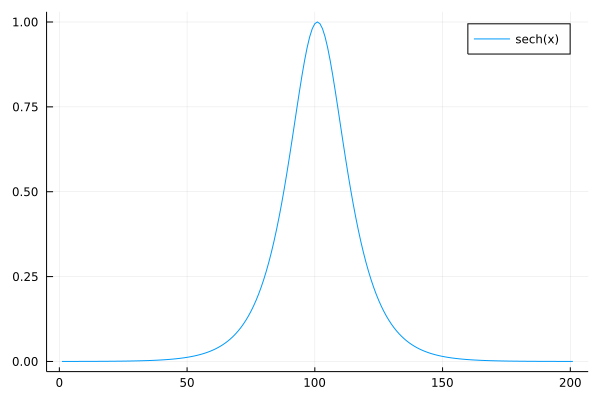

In [1]:
using Plots
x = -10:0.1:10;
plot(sech.(x), label="sech(x)")

Let's proceed by transforming (TW) into a first-order system of ODEs by setting

\begin{eqnarray*}
w = \phi'.
\end{eqnarray*}

This gives us the first-order system (S)
\begin{eqnarray}
\phi' & = & w \\
w' & = & \phi + \frac{1}{2c} \phi^2.
\end{eqnarray}

Let's proceed by solving system (S) numerically in Julia. We'll do so using the `DifferentialEquations` package to define our system.

In [2]:
using DifferentialEquations

In [3]:
function g!(du, u, p, t)
    du[1] = u[2]
    du[2] = u[1] + (1/(2p[1]))u[1]^2
end

g! (generic function with 1 method)

Notice we defined our system using the above function `g!`, with system components $\phi$ and $w$ denoted by the Array `u`, and system parameter (the wave-speed) $c$ denoted by the parameter Array `p`, and position variable $y$ denoted by $t$.

Before we solve, we should translate our boundary conditions at infinity to some initial conditions, because `ODEProblem` tool we'll be using is expecting that. 

Let's think about what the center of the wave-profile might look like. The wave will arrive, reach its maximum, then vanish. At the maximum, it must be the case the case that $w = 0$ (by definition of $w$). Therefore we will try out initial conditions of the form $(\phi_0, 0)$ to discover our solution.

We'll also need to set "time-spans" and a parameter value for $c$, which we'll pick to be $(0, 20)$ and $-1$ respectively.

In [4]:
tspan = (0,20.0);
c = -1.1;
p = [c];

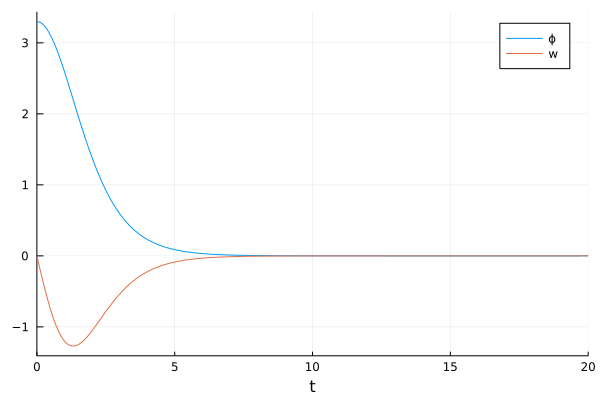

In [5]:
u0 = [3.3, 0.0]
  prob = ODEProblem(g!,u0,tspan,p);
  #sol = solve(prob,Tsit5());
  sol = solve(prob, saveat = 0.01, abstol = 1e-9, reltol = 1e-9)
  plot(sol,label=["ϕ" "w"])

We can see that we indeed get a localized, pulse-like solution with wave speed $c = -1.1$ and amplitude $\phi_0 = 3.3$. One thing to note is that we only see half of the pulse since we set our initial condition to get at the top of the wave. Let's solve again using a point on the 'tail' of the wave as the initial condition.

I'll get the value of the solution at 'time' $t = 10$, get the index of that time using `sol.t`, then 'reverse' the initial condition:

In [6]:
#sol.t[1001]
sol[1001]

2-element Vector{Float64}:
  0.0005992271381934171
 -0.0005991677807230789

What I'm really going for is an initial condition with the above values, except that the second component should be positive. This makes sense, since the second variable is the derivative of the wave shape, and on the initial end of the pulse, this should be increasing and hence positive.

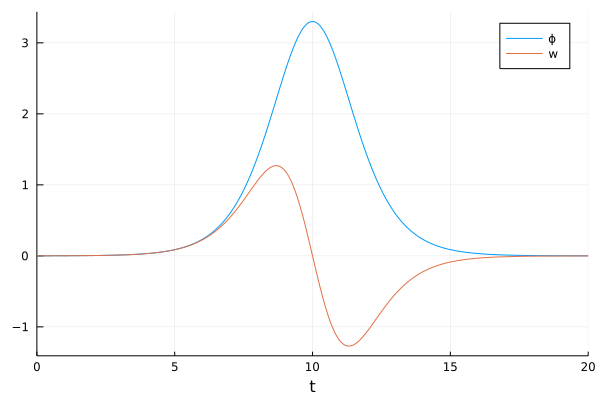

In [7]:
u0 = [0.0005992271381934171, 0.0005991677807230789];
  
  prob = ODEProblem(g!,u0,tspan,p);
  #sol = solve(prob,Tsit5());
  sol = solve(prob, saveat = 0.01, abstol = 1e-9, reltol = 1e-9)
  plot(sol,label=["ϕ" "w"])

Now we can see we have a perfectly centered Traveling Wave pulse for our system!

Let's view our wave at various times as it would move physically through the system with the given speed $c=-1.1$. We'll solve the system multiple times with initial conditions coming from our wave above:

In [8]:
solA = Array(sol);
### solve multiple times using different IC
ICs = [solA[:, t] for t in 1:100:1000];
problem(ic) = prob = ODEProblem(g!,ic,tspan,p);
sols = [solve(problem(ic), saveat = 0.01, abstol = 1e-9, reltol = 1e-9) for ic in ICs];

Now we'll plot our solutions at the various times:

In [14]:
plot(sols[1],label="ϕ at time 1", vars=(0, 1), color=RGBA(.8, 0, .75, 0.1), legend=false);
#plot!(sols[2],label=["phi" "phi dot"], vars=(0, 1))
for t in 2:9
    plot!(sols[t],label="ϕ at time "*string(t), vars=(0, 1), color=RGBA(.8, 0, .75, 0.1*t), legend=false)
end

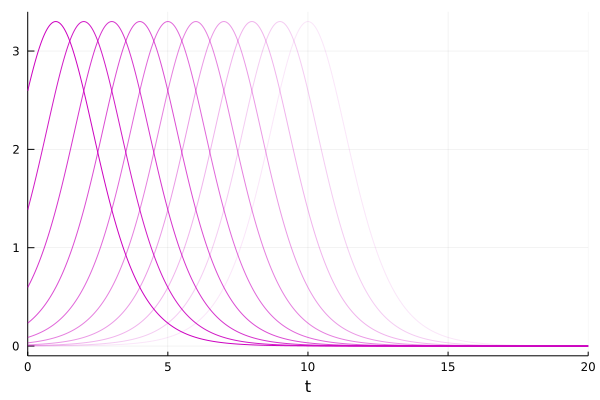

In [15]:
plot!(sols[10],label="ϕ at time 10", vars=(0, 1), color=RGBA(.8, 0, .75, 1))

In the above plot, we can see our wave moving to the left at speed $c=-1.1$; the more transparent, faded waves indicate the position of the wave at previous times.

## Parameter Estimation

One thing to try next would be to choose the amplitude parameter to maximize the period length. This could be attempted using Julia's Black Box Optimizer `BBOptim`.

# Comparison with Exact Solution

One nice thing about system (S) is that it is possible to find exact solutions for it. This is possible because it turns out to be a Hamiltonian system; that is, the system possesses a conserved quantity, unchanging across trajectories, that generates the equations of the system. 

A general Hamiltonian system of ODEs satisfies 

\begin{eqnarray}
\frac{dx}{dt} & = & -\frac{\partial H} {\partial y} \\
\frac{dy}{dt} & = & \frac{\partial H} {\partial x}
\end{eqnarray}

where $x, y \in \mathbb{R}^n$ and $H(x,y)$ is a smooth scalar function called the Hamiltonian. One can check that $\frac{dH}{dt}=0$ along trajectories of this system and hence $H$ is a conserved quantity.

We'll proceed by writing down the Hamiltonian for system (S):

\begin{eqnarray}
H(\phi, w) = -\frac{1}{2} w^2 + \frac{1}{2} \phi^2 + \frac{1}{6c} \phi^3.
\end{eqnarray}

Observe that $-H_w = w = \phi'$ and $H_{\phi} = \phi + \frac{1}{2c} \phi^2 = w'$, and hence system (S) is Hamiltonian.

Recall our boundary conditions at infinity; in these variables they imply that $\phi = 0$ and $w = 0$ at infinity (so that the pulse has horizontal asymptotes of zero). 

However, because the system is Hamiltonian, we can use the conserved quantity for $H(0,0)$ and solve for a solution curve of our system.

By plugging in $\phi = 0$ and $w = 0$ into $H$, we get 

\begin{eqnarray}
H(0,0) = 0.
\end{eqnarray}

Then we can solve for $w$ in terms of $\phi$, giving the solution curve

\begin{eqnarray}
w = \pm \phi \sqrt{1 + \frac{1}{3c} \phi}.
\end{eqnarray}

Let's go ahead and plot this solution curve in the $(\phi, w)$ phase plane.

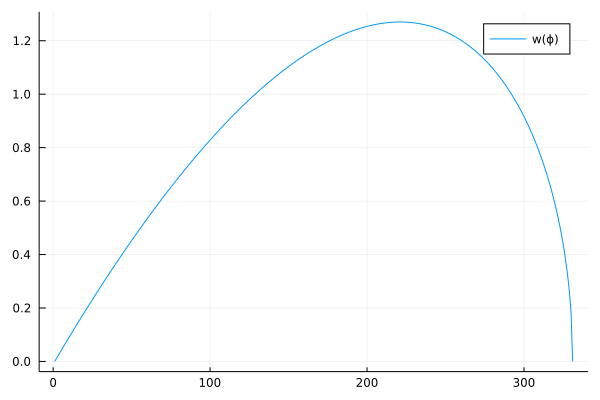

In [11]:
ϕ = 0.0:0.01:3.30;
plot(ϕ.*sqrt.(1 .+(1/3c)*ϕ), label="w(ϕ)")

We can see that this agrees closely with the analogous plot from our computed solution for $w$ vs $\phi$:

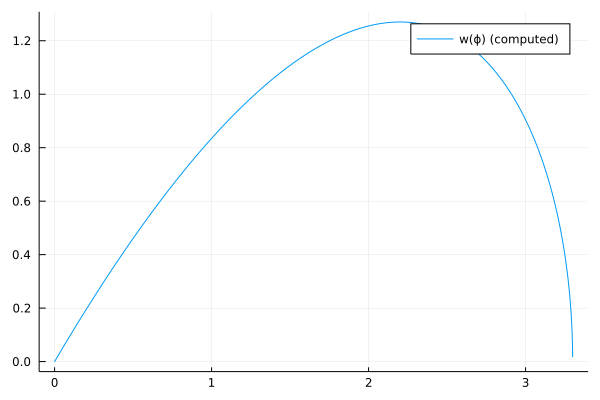

In [12]:
plot(solA[1, 1:1000], solA[2, 1:1000], label="w(ϕ) (computed)")
#plot(sol(1:0.1:10), vars=(0))

In fact, for this system it turns out we can do even better: we can substitute the relation gained from using the Hamiltonian back into the first equation in (S), giving us a separable ODE for $\phi$:

\begin{eqnarray}
\int \frac{d\phi}{\phi \sqrt{1 + \frac{1}{3c} \phi}} = \int dy.
\end{eqnarray}

Carrying out the integration and solving for $\phi$ yields 
\begin{eqnarray}
\DeclareMathOperator{\sech}{sech}
\large
\phi(y) = -\frac{3}{c} \sech^2\left(\frac{y}{2}\right).
\end{eqnarray}

We can plot this exact solution and see that it agrees closely with our Julia plotted solutions throughout the notebook:

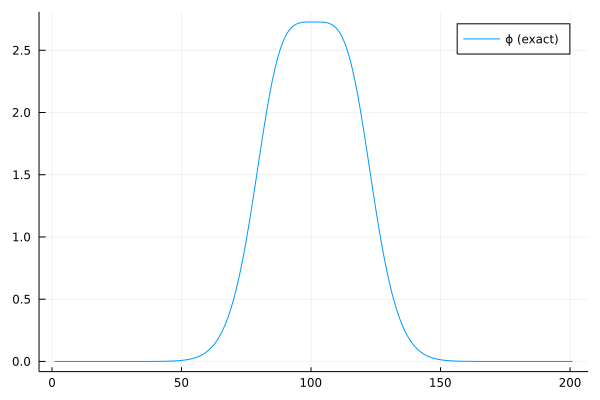

In [13]:
x = -10:0.1:10;
plot((-3/-1.1)sech.((x/2).^2), label="ϕ (exact)")